In [1]:
# preparing the tools
import networkx as nx
import pandas as pd
import numpy as np
import pickle
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

# Company Emails

This project making predictions about networks : will edges be formed. We will using a company's email network `email_prediction.txt`.

## 1. Data

Each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes Department and ManagementSalary.

Department indicates the department in the company which the person belongs to, and ManagementSalary indicates whether that person is receiving a management position salary.

The future connections information has been loaded into the `Future_Connections.csv`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the Future Connection column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

## 2. Problem Definition

* 2A : predict whether or not these individuals are receiving a management position salary.
* 2B : predict future connections between employees of the network.


### Data Analysis

In [2]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


<IPython.core.display.Javascript object>


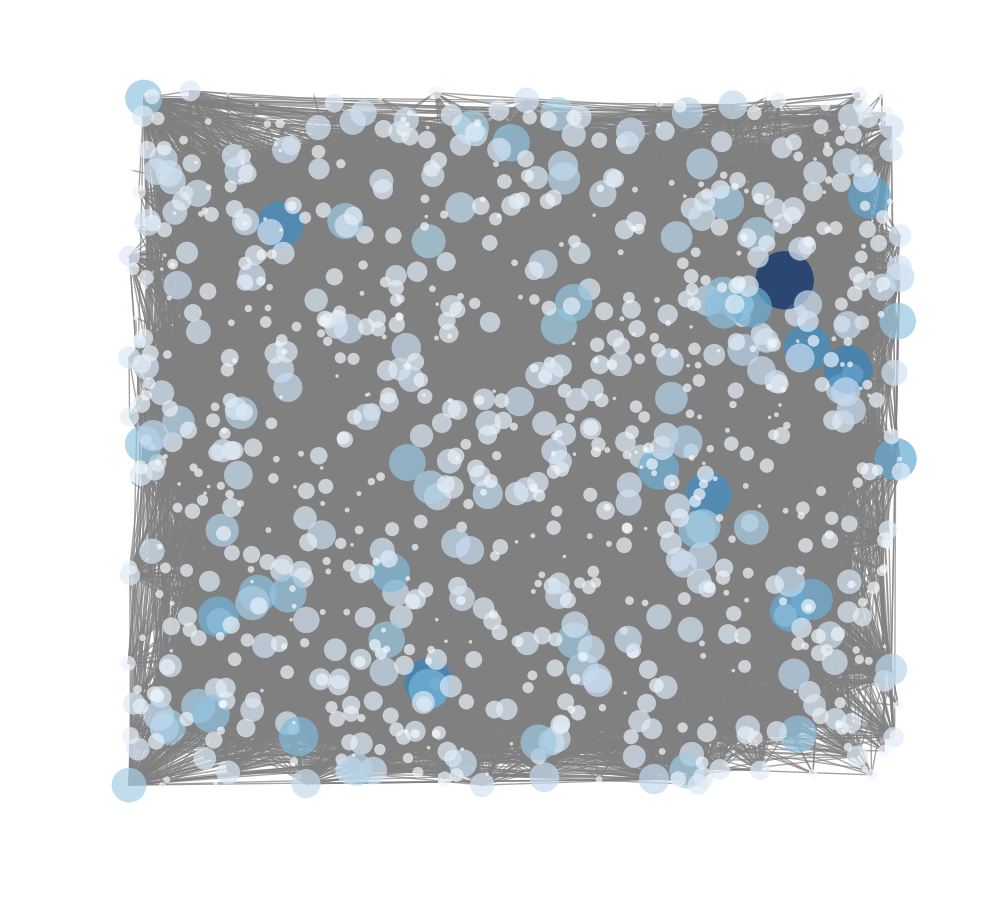

In [3]:
plt.figure(figsize=(10,9))
pos = nx.random_layout(G)

node_color = [G.degree(v) for v in G]
node_size = [5*G.degree(v) for v in G]

nx.draw_networkx(G, pos, node_size=node_size, node_color=node_color, 
                 alpha=0.7, with_labels=False, edge_color='.5', cmap=plt.cm.Blues)

plt.axis('off')
plt.tight_layout();
plt.show()

### 2A : Salary prediction

To accomplish this, we shall need to

* Create a matrix of node features
* Train a sklearn classifier on nodes that have ManagementSalary data
* Predict a probability of the node receiving a managment salary for nodes where ManagementSalary is missing.

Let's create a data frame of network G.

In [4]:
# create a data frame for all workers
df = pd.DataFrame(G.nodes(), columns=['Worker'])
df['Department'] = pd.Series(nx.get_node_attributes(G, 'Department'))
df['ManagementSalary'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
df.head()

,Worker,Department,ManagementSalary
0,0,1,0.0
1,1,1,NaN
2,2,21,NaN
3,3,21,1.0
4,4,21,1.0


Let's identify the people in the network with missing values for the node attribute ManagementSalary. In this way, we'll create 2 data sets : workers who have salary - train, the remaining - test.

In [5]:
# create train and test sets
train_df = df.dropna()
test_df = df[np.isnan(df['ManagementSalary'])]

#  create a matrix of node features
X_train = train_df[['Worker', 'Department']]
y_train = train_df['ManagementSalary']
X_test = test_df[['Worker', 'Department']]
X_train.shape, X_test.shape, y_train.shape

((753, 2), (252, 2), (753,))

<IPython.core.display.Javascript object>


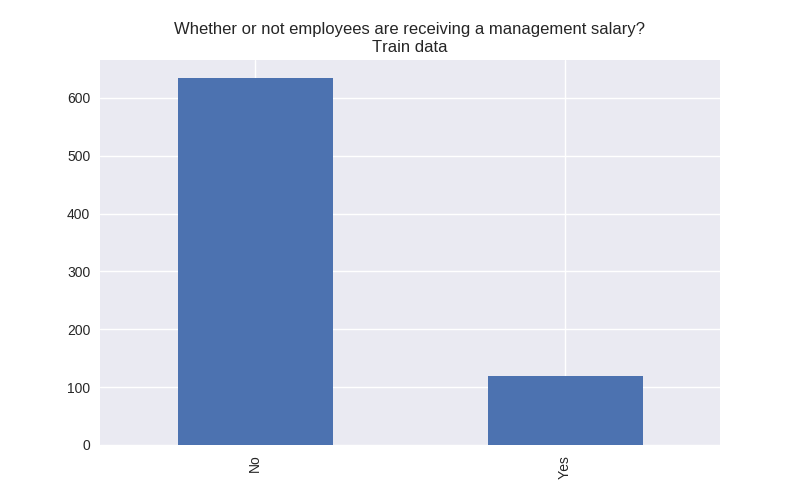

In [6]:
plt.figure(figsize=(8,5))
train_df['ManagementSalary'].value_counts().plot(kind="bar");
plt.title("Whether or not employees are receiving a management salary?\nTrain data");
plt.xticks(np.arange(2), ('No', 'Yes'))
plt.show();

Now we'll train a sklearn classifier on nodes that have ManagementSalary data, and predict a probability of the node receiving a management salary for nodes where ManagementSalary is missing

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

# create a model and fit it
model = GradientBoostingClassifier().fit(X_train, y_train)
# get the result    
predictions = model.predict_proba(X_test)[:, 1]
result = pd.Series(predictions, index=list(test_df['Worker']))
result.head()

1     0.019248
2     0.914392
5     0.929025
8     0.117703
14    0.323648
dtype: float64

<IPython.core.display.Javascript object>


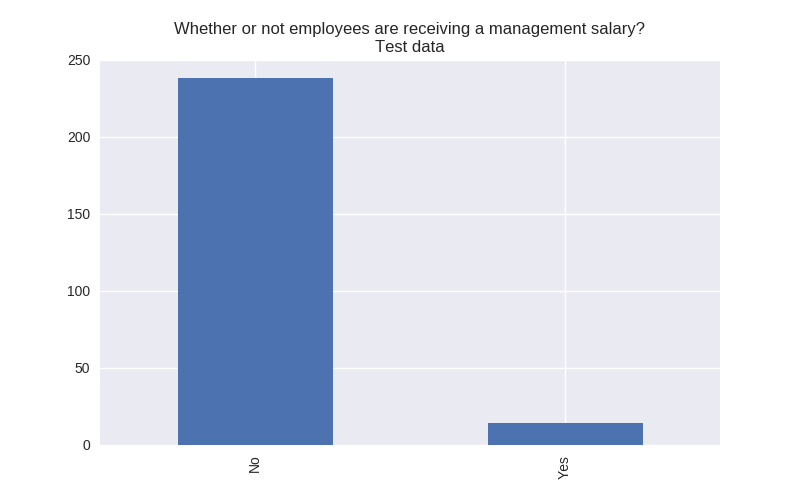

In [8]:
res_dict = {'No' : 0, 'Yes' : 0}
for res in result:
    if res >= 0.5:
        res_dict['Yes'] += 1
    else:
        res_dict['No'] += 1

res_df = pd.Series(res_dict)

plt.figure(figsize=(8,5))
res_df.plot(kind="bar");
plt.title("Whether or not employees are receiving a management salary?\nTest data");
plt.show();

### 2B : New Connections Prediction

To accomplish this, we shall need to

* Create a matrix of features for the edges found in future_connections
* Train a sklearn classifier on those edges in future_connections that have Future Connection data
* Predict a probability of the edge being a future connection for those edges in future_connections where Future Connection is missing.

Let's load the future connections information.

In [9]:
# load data
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head()

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0


Let's create a data frame with loaded data. We need choose a measure for link prediction:

* Common Neighbors - the number of common neighbors of two nodes.
* Preferential attachment - product of nodes degree.

In [10]:
df = future_connections.reset_index()
# we will use 2 input features for each edge:
# Preferential attachment and Common Neighbors
common_neighbors = []
preferential_attachment = []
for i in range(len(df)):
    pair = df.iloc[i]['index']
    pref_att = list(nx.preferential_attachment(G, [pair]))[0][2]
    neigh = len(list(nx.common_neighbors(G, pair[0], pair[1])))
    preferential_attachment.append(pref_att)
    common_neighbors.append(neigh)
    
# add Preferential attachment and Common Neighbors columns to df
df['Preferential attachment'] = preferential_attachment
df['Common Neighbors'] = common_neighbors
df.head()

,index,Future Connection,Preferential attachment,Common Neighbors
0,"(6, 840)",0.0,2070,9
1,"(4, 197)",0.0,3552,2
2,"(620, 979)",0.0,28,0
3,"(519, 872)",0.0,299,2
4,"(382, 423)",0.0,205,0


In [11]:
# create train and test sets : workers who have future connections - train, the remaining - test
train_df = df.dropna()
test_df = df[np.isnan(df['Future Connection'])]

X_train, X_test = [], []
y_train = train_df['Future Connection']

for i in range(len(train_df)):
    X_train.append([train_df.iloc[i]['Preferential attachment'], train_df.iloc[i]['Common Neighbors']])
X_train = np.array(X_train)

for i in range(len(test_df)):
    X_test.append([test_df.iloc[i]['Preferential attachment'], test_df.iloc[i]['Common Neighbors']])
X_test = np.array(X_test)
X_train.shape, X_test.shape, y_train.shape

((366334, 2), (122112, 2), (366334,))

<IPython.core.display.Javascript object>


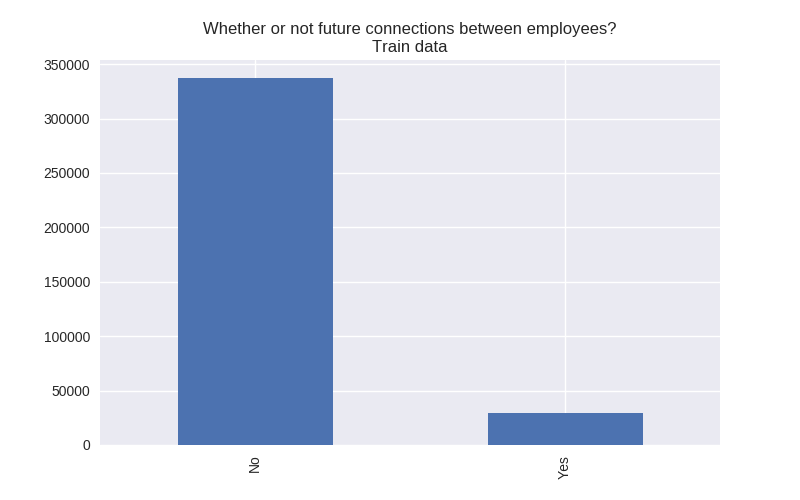

In [12]:
plt.figure(figsize=(8,5))
train_df['Future Connection'].value_counts().plot(kind="bar");
plt.title("Whether or not future connections between employees?\nTrain data");
plt.xticks(np.arange(2), ('No', 'Yes'))
plt.show();

Now we'll train a sklearn classifier on those edges in future_connections that have Future Connection data, and predict a probability of the edge being a future connection for those edges in future_connections where Future Connection is missing.

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

# create a model and fit it
model = GradientBoostingClassifier().fit(X_train, y_train) 
# get the result 
predictions = model.predict_proba(X_test)[:, 1]
result = pd.Series(predictions, index=list(test_df['index']))
result.head()

(107, 348)    0.031823
(542, 751)    0.012931
(20, 426)     0.543026
(50, 989)     0.013104
(942, 986)    0.013103
dtype: float64

<IPython.core.display.Javascript object>


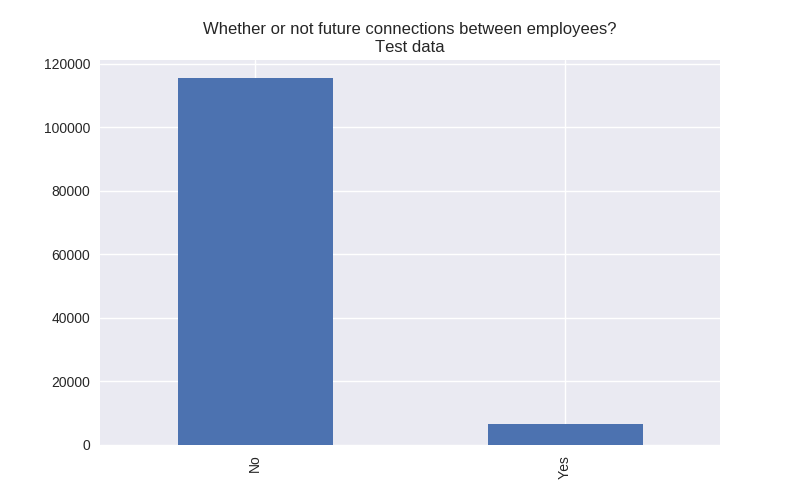

In [14]:
res_dict = {'No' : 0, 'Yes' : 0}
for res in result:
    if res >= 0.5:
        res_dict['Yes'] += 1
    else:
        res_dict['No'] += 1

res_df = pd.Series(res_dict)

plt.figure(figsize=(8,5))
res_df.plot(kind="bar");
plt.title("Whether or not future connections between employees?\nTest data")
plt.show();